In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy import linalg
import math
import random as rd

In [2]:
# A function to read the data has defined to identify the features and labels by separating it with "," 
def read_data(data_file):
    data = pd.read_table(data_file, sep=',') 
    attributes = len(data.values[0])
    X = data.values[0:, 0:attributes-1]
    y = data.values[0:, attributes-1]
    return X, y

In [3]:
X, y =read_data('optdigits.tra')

# Question 1

In [4]:
def Covariance(X):
    meanX= X.mean(axis=0)
    lenX=X.shape[0]
    X=X-meanX
    covariance= X.T.dot(X)/lenX #(xi-x)/lenX
    return covariance

In [5]:
X_meaned=X-np.mean(X, axis=0) # I centred data according to the columnwise featurewise means
covariance= Covariance(X_meaned) # since I will use the eigenvectors of covariance, first I calculate the covariance matrix of meaned data

In [6]:
vals, vecs= np.linalg.eigh(covariance) # eigenvalues (vals) and corresponding eigenvectors (vecs) are calculated
sort= np.argsort(vals)[::-1] # vals and vecs are sorted in descending order
sort_vals=vals[sort]
sort_vecs=vecs[:,sort]
eigs=sort_vecs[:,0:2] # since I will project data in 2 dimensional space, I handle the first two eigenvectors which eigenvalues are highest

In [7]:
Projected_data= np.dot(eigs.T, X_meaned.T).T # now I can project data using eigenvectors

In [11]:
Projected_data

array([[ 16.47066023,  13.06427629],
       [-18.8354863 , -10.7285293 ],
       [-12.87056402, -17.62207873],
       ...,
       [ 24.13644735,  -5.75804707],
       [ 29.35348492,   3.44248544],
       [-24.99486122, -11.82102336]])

In [690]:
P=pd.DataFrame(Projected_data)
P.columns = ['z1', 'z2']
P['labels'] = y # I add labels for visualization

<Figure size 2160x720 with 0 Axes>

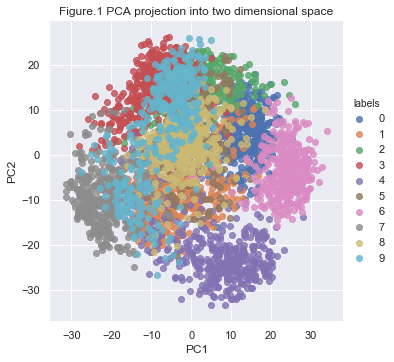

In [818]:
plt.figure(figsize=(30,10))
ax = sns.lmplot(data=P, x='z1', y='z2', hue='labels', 
                   fit_reg=False, legend=True, legend_out=True)
ax.set(xlabel='PC1', ylabel='PC2')
plt.title('Figure.1 PCA projection into two dimensional space')
plt.show()

# Question 2

In [712]:
data=pd.DataFrame(X)
data['labels']=pd.DataFrame(y) #Unlikely to PCA, now I can use labels for LDA. 

In [722]:
#first I define the within the class scatter matrix (Sw) and between the class scatter matrix (Sb). 
def Sw(U):
    labels = U.iloc[:,-1]
    num_class=len(list(Counter(labels).keys()))
    classes=list(Counter(labels).keys())
    sw=np.zeros((64,64))
    for i in range(0, num_class):
        c=U.loc[data['labels'] == classes[i]]
        c=c.iloc[:,:64]
        c_meaned=c-np.mean(c, axis=0)
        sw += c_meaned.T.dot(c_meaned)+0.000001*np.random.rand(64,64) # second term is added so that Sw can be singular matrix. 
    return sw

In [723]:
def Sb(U):
    labels = U.iloc[:,-1]
    num_class=len(list(Counter(labels).keys()))
    classes=list(Counter(labels).keys())
    m_all=U.iloc[:,:64].mean(axis = 0).to_numpy()
    sb=np.zeros((64,64))
    for i in range(0, num_class):
        c=U.loc[data['labels'] == classes[i]]
        m=c.iloc[:,:64].mean(axis = 0).to_numpy()
        k=np.array([m-m_all])
        sb += (k.T.dot(k))*len(c)
    return sb

In [724]:
SW=Sw(data)
SB=Sb(data)

In [725]:
vals, vecs= linalg.eig(SB, SW) #generalized eigenvalue problem is solved using Sb and Sw matrix
sort= np.argsort(vals)[::-1] # vals and vecs are sorted in descending order
sort_vals=vals[sort]
sort_vecs=vecs[:,sort]
eigens=sort_vecs[:,0:2] # since I will project data in 2 dimensional space, I handle the first two eigenvectors which eigenvalues are highest

In [726]:
Projected_data_L= np.dot(eigens.T, X.T).T # now I can project data using eigenvectors

In [727]:
L=pd.DataFrame(Projected_data_L)
L['labels'] = data['labels']

<Figure size 720x720 with 0 Axes>

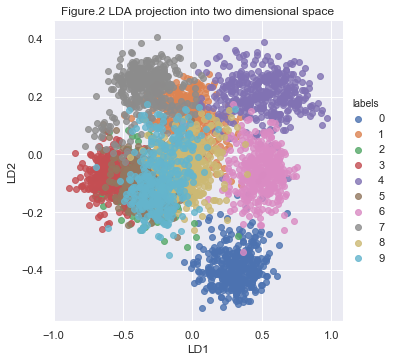

In [830]:
plt.figure(figsize=(10,10))
ax = sns.lmplot(data=L, x='z1', y='z2', hue='labels', 
                   fit_reg=False, legend=True, legend_out=True)
ax.set(xlabel='LD1', ylabel='LD2')
plt.title('Figure.2 LDA projection into two dimensional space')
plt.show()

# Question 3

In [762]:
data=pd.read_csv('cluster_data.csv') #load data here

In [763]:
def Kmeans(data, K, num_iter):
    # given data, cluster number (K), and number of iterations (num_iter), k-means clustersing is implemented by Kmeans function.
    X=data.values
    num_sample=X.shape[0] 
    num_feature=X.shape[1]
    centers=np.array([]).reshape(num_feature,0) # empty array is generated in order to define the centers of clusters 
    for i in range(K):
        value=rd.randint(0,num_sample-1)
        centers=np.c_[centers,X[value]] # random values for centers are generated 
    Clusters={}
    euclidian_distance=np.array([]).reshape(num_sample,0) # empty array is generated to define euclidian distances between centers and daha points
    for k in range(K):
        EC=np.sum((X-centers[:,k])**2,axis=1)
        euclidian_distance=np.c_[euclidian_distance,EC]
    C_data=np.argmin(euclidian_distance,axis=1)+1 # I've found minimum distance to centers to assign data points to their minimum distance center 
    New_Clusters={} # empty dictionnary to find new centers according to the data assigned 
    for k in range(K):
        New_Clusters[k+1]=np.array([]).reshape(2,0)
    for i in range(num_sample):
        New_Clusters[C_data[i]]=np.c_[New_Clusters[C_data[i]],X[i]]     
    for k in range(K):
        New_Clusters[k+1]=New_Clusters[k+1].T    
    for k in range(K):
        centers[:,k]=np.mean(New_Clusters[k+1],axis=0) # mean of clusters are assigned as centers 
        
    #now I've iterated previous code num_iter times   
    for i in range(num_iter):
        euclidian_distance=np.array([]).reshape(num_sample,0)
        for k in range(K):
            EC=np.sum((X-centers[:,k])**2,axis=1)
            euclidian_distance=np.c_[euclidian_distance,EC]
        C_data=np.argmin(euclidian_distance,axis=1)+1
        New_Clusters={}
        for k in range(K):
            New_Clusters[k+1]=np.array([]).reshape(2,0)
        for i in range(num_sample):
            New_Clusters[C_data[i]]=np.c_[New_Clusters[C_data[i]],X[i]]
        for k in range(K):
            New_Clusters[k+1]=New_Clusters[k+1].T    
        for k in range(K):
            centers[:,k]=np.mean(New_Clusters[k+1],axis=0)
        Output=New_Clusters
    return Output, centers

In [764]:
Output2, Centers2= Kmeans(data, 2, 200)
Output3, Centers3= Kmeans(data, 3, 200)

In [765]:
X=data.values

In [846]:
sns.set_style("white")
plt.figure(figsize=(10,5))

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

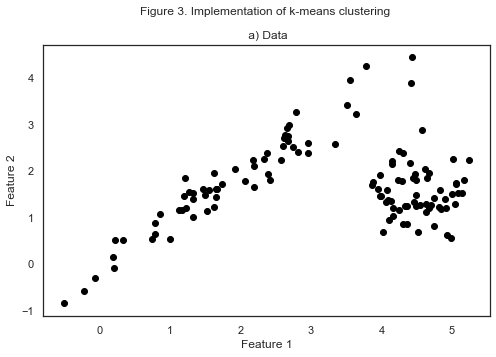

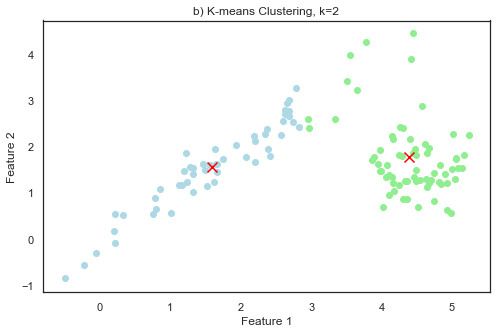

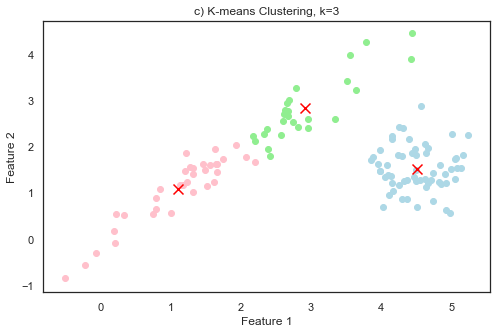

In [865]:
plt.figure(figsize=(8, 5))
plt.scatter(X[:,0],X[:,1],c='black',label='data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Figure 3. Implementation of k-means clustering \n \n a) Data')
plt.show()

color=['lightgreen','lightblue','pink']
labels=['cluster1','cluster2','cluster3']

plt.figure(figsize=(8, 5))
for k in range(2):
    plt.scatter(Output2[k+1][:,0],Output2[k+1][:,1],c=color[k],label=labels[k])
plt.scatter(Centers2[0,:],Centers2[1,:],s=100,c='red',marker='x',label='Centroids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('b) K-means Clustering, k=2')
plt.show()

plt.figure(figsize=(8, 5))
for k in range(3):
    plt.scatter(Output3[k+1][:,0],Output3[k+1][:,1],c=color[k],label=labels[k])
#plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(Centers3[0,:],Centers3[1,:],s=100,c='red',marker='x',label='Centroids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('c) K-means Clustering, k=3')
plt.show()

# Question 4

In [768]:
#probability density function for gaussian distribution
def p(data, val, mu, cov):
    p=(1/(((2*math.pi)**(len(data)/2))*(np.linalg.det(cov)**1/2)))*math.exp(-1/2*(np.linalg.multi_dot([(val-mu).T, np.linalg.inv(cov), (val-mu)])))
    return p

In [769]:
#expectation step of EM algorithm. In this step, I assigned label to each data point according to its probability of belonging one class
#to start expectation step one needs to initiliaze parameters of p
def expectation(data, parameters):
    for i in range (0, len(data)):
        x1=data['0'][i]
        x2=data['1'][i]
        p0= p(data, np.array([x1,x2]),np.array(parameters['mean1'][0]), np.array(parameters['cov1'][0]))
        p1= p(data, np.array([x1,x2]),np.array(parameters['mean2'][0]), np.array(parameters['cov2'][0]))
        if p0 > p1:
            data.iloc[i,2]=0
        else:
            data.iloc[i,2]=1
    return data 

In [770]:
#maximization step of EM algorithm. In this step, I've recalculated the parameters of p using the labels that are assigned on expectation step 
def maximization(data, parameters):
    set0=data.loc[data['labels']==0]
    set1=data.loc[data['labels']==1]
    M_lmd1=len(set0)/len(data)
    M_lmd2=len(set1)/len(data)
    parameters['lmd1']=[M_lmd1]
    parameters['lmd2']=[M_lmd2]
    parameters['mean1']=[list(set0.iloc[:,:2].mean(axis = 0))]
    parameters['mean2']=[list(set1.iloc[:,:2].mean(axis = 0))]
    parameters['cov1']= [Covariance(set0.iloc[:,:2]).values.tolist()]
    parameters['cov2']= [Covariance(set1.iloc[:,:2]).values.tolist()]
    return parameters

In [771]:
#difference between the initial parameters at the beginning of the expectation step and the output of the maximization step 
def difference(prior_parameters, updated_parameters):
    diff = 0
    for i in ['mean1', 'mean2']:
        for j in range(len(prior_parameters)):
            diff += (prior_parameters[i][0][j] - updated_parameters[i][0][j]) ** 2
            return diff ** 0.5

In [772]:
data3= pd.read_csv('C:\\Users\\Lenovo\\Desktop\\Dersler_Lenovo\\Machine Learning\\2020-2021_Yusuf Yaslan\\HM3\\cluster_data.csv', index_col=0)

In [773]:
#initial guess
cluster_1 = data3.head(30)
cluster_2=data3.tail(90)
mean_1=list(cluster_1.mean(axis=0))
mean_2=list(cluster_2.mean(axis=0))
cov_1=Covariance(cluster_1).values.tolist()
cov_2=Covariance(cluster_2).values.tolist()
columns=['mean1', 'mean2','cov1', 'cov2', 'lmd1' ,'lmd2']
prior_parameters=pd.DataFrame(columns=columns)
prior_parameters['mean1']=[mean_1]
prior_parameters['mean2']=[mean_2]
prior_parameters['cov1']=[cov_1]
prior_parameters['cov2']=[cov_2]
prior_parameters['lmd1']=len(cluster_1)/(len(cluster_1)+len(cluster_2))
prior_parameters['lmd2']=len(cluster_2)/(len(cluster_1)+len(cluster_2))

In [774]:
data=data3.copy()
data['labels'] = 'nan'

In [775]:
i=0
k=1
while k>0.001:
    i+=1
    new_labels= expectation(data.copy(), prior_parameters)
    new_parameters= maximization(new_labels, prior_parameters.copy())
    k= difference(prior_parameters, new_parameters)
    data= new_labels
    prior_parameters= new_parameters

In [784]:
def difference3(prior_parameters, updated_parameters):
    diff = 0
    for i in ['mean1', 'mean2', 'mean3']:
        for j in range(len(prior_parameters)):
            diff += (prior_parameters[i][0][j] - updated_parameters[i][0][j]) ** 2
            return diff ** 0.5

In [778]:
def expectation3(data, parameters):
    for i in range (0, len(data)):
        x1=data['0'][i]
        x2=data['1'][i]
        p1= p(data, np.array([x1,x2]),np.array(parameters['mean1'][0]), np.array(parameters['cov1'][0]))
        p2= p(data, np.array([x1,x2]),np.array(parameters['mean2'][0]), np.array(parameters['cov2'][0]))
        p3= p(data, np.array([x1,x2]),np.array(parameters['mean3'][0]), np.array(parameters['cov3'][0]))
        if p1 > p2:
            if p1<p3:
                data.iloc[i,2]=3
            else:
                data.iloc[i,2]=1
        else:
            if p2<p3:
                data.iloc[i,2]=3 
            else:
                data.iloc[i,2]=2
    return data 

In [779]:
def maximization3(data, parameters):
    set1=data.loc[data['labels']==1]
    set2=data.loc[data['labels']==2]
    set3=data.loc[data['labels']==3]
    M_lmd1=len(set1)/len(data)
    M_lmd2=len(set2)/len(data)
    M_lmd3=len(set3)/len(data)
    parameters['lmd1']=[M_lmd1]
    parameters['lmd2']=[M_lmd2]
    parameters['lmd3']=[M_lmd3]
    parameters['mean1']=[list(set1.iloc[:,:2].mean(axis = 0))]
    parameters['mean2']=[list(set2.iloc[:,:2].mean(axis = 0))]
    parameters['mean3']=[list(set3.iloc[:,:2].mean(axis = 0))]
    parameters['cov1']= [Covariance(set1.iloc[:,:2]).values.tolist()]
    parameters['cov2']= [Covariance(set2.iloc[:,:2]).values.tolist()]
    parameters['cov3']= [Covariance(set3.iloc[:,:2]).values.tolist()]
    return parameters

In [780]:
#initial guess
cluster_1 = data3.head(30)
cluster_2=data3.tail(90)
cluster_3=data3.head(60)
mean_1=list(cluster_1.mean(axis=0))
mean_2=list(cluster_2.mean(axis=0))
mean_3=list(cluster_3.mean(axis=0))
cov_1=Covariance(cluster_1).values.tolist()
cov_2=Covariance(cluster_2).values.tolist()
cov_3=Covariance(cluster_3).values.tolist()
columns=['mean1', 'mean2',  'mean3','cov1', 'cov2', 'cov3', 'lmd1' ,'lmd2','lmd3']
prior_parameters=pd.DataFrame(columns=columns)
prior_parameters['mean1']=[mean_1]
prior_parameters['mean2']=[mean_2]
prior_parameters['mean3']=[mean_3]
prior_parameters['cov1']=[cov_1]
prior_parameters['cov2']=[cov_2]
prior_parameters['cov3']=[cov_3]
prior_parameters['lmd1']=len(cluster_1)/(len(cluster_1)+len(cluster_2)+len(cluster_3))
prior_parameters['lmd2']=len(cluster_2)/(len(cluster_1)+len(cluster_2)+len(cluster_3))
prior_parameters['lmd3']=len(cluster_3)/(len(cluster_1)+len(cluster_2)+len(cluster_3))

In [781]:
data3= pd.read_csv('C:\\Users\\Lenovo\\Desktop\\Dersler_Lenovo\\Machine Learning\\2020-2021_Yusuf Yaslan\\HM3\\cluster_data.csv', index_col=0)

In [782]:
data3=data3.copy()
data3['labels'] = 'nan'

In [785]:
i=0
k=1
while k>0.001:
    i+=1
    new_labels= expectation3(data3.copy(), prior_parameters)
    new_parameters= maximization3(new_labels, prior_parameters.copy())
    k= difference3(prior_parameters, new_parameters)
    data3= new_labels
    prior_parameters= new_parameters

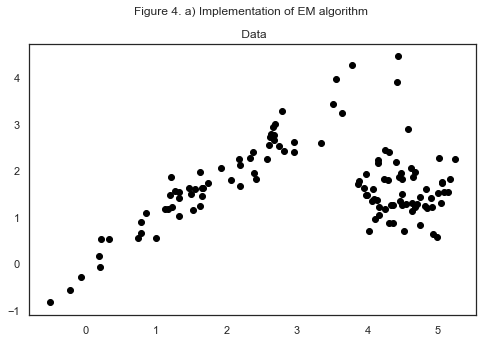

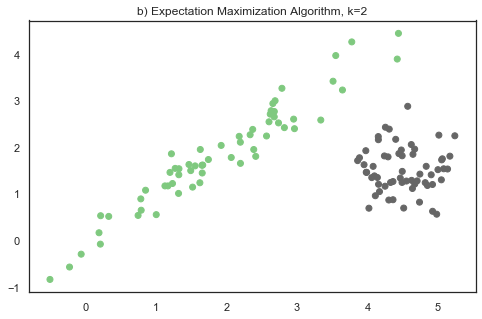

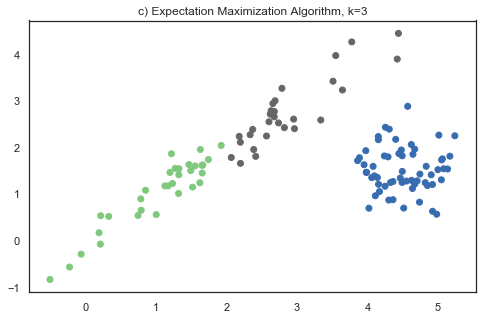

In [883]:
plt.figure(figsize=(8, 5))
plt.scatter(data['0'], data['1'], c='black')
plt.title('Figure 4. a) Implementation of EM algorithm \n \n Data')
plt.show()
plt.figure(figsize=(8, 5))
plt.scatter(data['0'], data['1'],  cmap='Accent', c=data['labels'])
plt.title('b) Expectation Maximization Algorithm, k=2')
plt.show()
plt.figure(figsize=(8, 5))
plt.scatter(data3['0'], data3['1'],  cmap='Accent',c=data3['labels'])
plt.title('c) Expectation Maximization Algorithm, k=3')
plt.show()